In [1]:
import pygame
from pygame.locals import *
from OpenGL.GL import *
from OpenGL.GLU import *
import random as rd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from math import ceil

seed = 9

rd.seed(seed)

pygame 2.5.0 (SDL 2.28.0, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
N_H = 1

N_O = ceil(N_H/2)

In [3]:
temperatura = 0

var_m_h = 1 
var_q_h = 2.5e-5
var_raio_h = 0.05


var_m_o = 16
var_q_o = -5e-5
var_raio_o = 0.17

var_g = 0
var_ex = 0
var_ey = 0
var_ez = 0

In [4]:
# Limites para os eixos x, y e z
x_limit = y_limit = z_limit = 2.0

In [5]:
dic_H = {}
dic_O = {}

for i in range(N_H):
    dic_H[f'H{i+1}x_0'] = rd.uniform(-x_limit,x_limit)
    dic_H[f'H{i+1}y_0'] = rd.uniform(-y_limit,y_limit)
    dic_H[f'H{i+1}z_0'] = rd.uniform(-z_limit,z_limit)
    dic_H[f'H{i+1}v_x_0'] = rd.uniform(-1,1)
    dic_H[f'H{i+1}v_y_0'] = rd.uniform(-1,1)
    dic_H[f'H{i+1}v_z_0'] = rd.uniform(-1,1)

for i in range(N_O):
    dic_O[f'O{i+1}x_0'] = rd.uniform(-x_limit,x_limit)
    dic_O[f'O{i+1}y_0'] = rd.uniform(-y_limit,y_limit)
    dic_O[f'O{i+1}z_0'] = rd.uniform(-z_limit,z_limit)
    dic_O[f'O{i+1}v_x_0'] = rd.uniform(-1,1)
    dic_O[f'O{i+1}v_y_0'] = rd.uniform(-1,1)
    dic_O[f'O{i+1}v_z_0'] = rd.uniform(-1,1)

In [6]:
particulas = []
for h in range(N_H):
    particulas.append(
        {
            "massa": var_m_h,
            "carga": var_q_h,
            "posicao": np.array(
                [dic_H[f"H{h+1}x_0"], dic_H[f"H{h+1}y_0"], dic_H[f"H{h+1}z_0"]]
            ),
            "velocidade": np.array(
                [dic_H[f"H{h+1}v_x_0"], dic_H[f"H{h+1}v_y_0"], dic_H[f"H{h+1}v_z_0"]]
            ),
            "raio": var_raio_h,
            "cor": (1.0, 1.0, 1.0)
        }
    )

for o in range(N_O):
    particulas.append(
        {
            "massa": var_m_o,
            "carga": var_q_o,
            "posicao": np.array(
                [dic_O[f"O{o+1}x_0"], dic_O[f"O{o+1}y_0"], dic_O[f"O{o+1}z_0"]]
            ),
            "velocidade": np.array(
                [dic_O[f"O{o+1}v_x_0"], dic_O[f"O{o+1}v_y_0"], dic_O[f"O{o+1}v_z_0"]]
            ),
            "raio": var_raio_o,
            "cor": (1.0, 0.0, 0.0)
        }
    )

In [7]:
def forca_coulombiana(q1, q2, pos1, pos2, k=8.988e9):
    r = np.linalg.norm(pos2 - pos1)
    direcao = (pos2 - pos1) / r
    forca = k * q1 * -q2 / (r**2) * direcao
    return forca

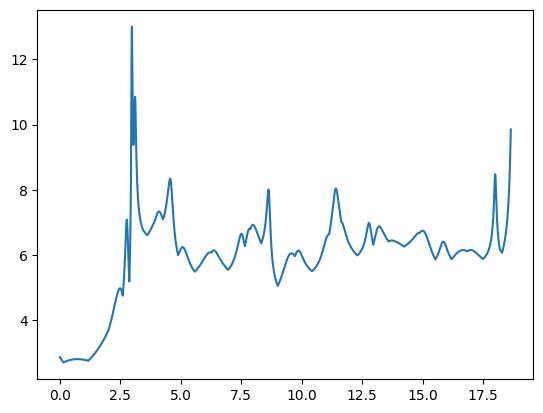

In [16]:
def draw_particle(particula, forcas, step=0.01):
    glPushMatrix()

    massa = particula['massa']
    posicao = particula['posicao']
    velocidade = particula['velocidade']
    raio = particula['raio']
    cor = particula['cor']
    aceleracao = sum(forcas) / massa
    nova_velocidade = velocidade + aceleracao * step

    # Gere um valor aleatório no intervalo [valor_minimo, valor_maximo]
    valor_aleatorio = np.random.uniform(-0.1, 0.1, *posicao.shape)

    nova_posicao = posicao + nova_velocidade * step + (valor_aleatorio * 0.01 *temperatura)

    # Verificar colisão com as bordas da caixa (dimensão x)
    if nova_posicao[0] - raio < -x_limit:
        nova_posicao[0] = -x_limit + raio
        nova_velocidade[0] *= -1  # Inverter a velocidade na direção x
    elif nova_posicao[0] + raio > x_limit:
        nova_posicao[0] = x_limit - raio
        nova_velocidade[0] *= -1  # Inverter a velocidade na direção x

    # Verificar colisão com as bordas da caixa (dimensão y)
    if nova_posicao[1] - raio < -y_limit:
        nova_posicao[1] = -y_limit + raio
        nova_velocidade[1] *= -1  # Inverter a velocidade na direção y
    elif nova_posicao[1] + raio > y_limit:
        nova_posicao[1] = y_limit - raio
        nova_velocidade[1] *= -1  # Inverter a velocidade na direção y

    # Verificar colisão com as bordas da caixa (dimensão z)
    if nova_posicao[2] - raio < -z_limit:
        nova_posicao[2] = -z_limit + raio
        nova_velocidade[2] *= -1  # Inverter a velocidade na direção z
    elif nova_posicao[2] + raio > z_limit:
        nova_posicao[2] = z_limit - raio
        nova_velocidade[2] *= -1  # Inverter a velocidade na direção z

    # Restrição de colisão entre partículas
    for outra_particula in particulas:
        if outra_particula is not particula:
            distancia_entre_particulas = np.linalg.norm(nova_posicao - outra_particula['posicao'])
            if distancia_entre_particulas < raio + outra_particula['raio']:
                direcao_colisao = (nova_posicao - outra_particula['posicao']) / distancia_entre_particulas
                nova_posicao = outra_particula['posicao'] + (raio + outra_particula['raio']) * direcao_colisao


    particula['posicao'] = nova_posicao
    particula['velocidade'] = nova_velocidade

    # Desenhar a partícula
    x, y, z = particula['posicao']

    glTranslatef(x, y, z)
    glColor3f(*cor)
    quad = gluNewQuadric()
    gluSphere(quad, raio, 20, 20)  # Esfera com raio 0.1
    gluDeleteQuadric(quad)
    glPopMatrix()

def desenhar_barra(altura, valor):
    largura_barra = 20
    margem = 5

    # Desenhe a barra preta
    glBegin(GL_QUADS)
    glColor3f(0, 0, 0)
    glVertex3f(window_width - largura_barra, 0, 0)
    glVertex3f(window_width, 0, 0)
    glVertex3f(window_width, altura, 0)
    glVertex3f(window_width - largura_barra, altura, 0)
    glEnd()

    # Calcule a altura da barra verde com base no valor da temperatura
    altura_barra_verde = (valor / 100) * (window_height - 2 * margem)

    # Defina as cores de referência (verde para temperatura mínima e vermelho para temperatura máxima)
    cor_minima = (0.0, 0.2, 1.0)
    cor_intermediaria = (0.0, 1.0, 0.0)
    cor_maxima = (1.0, 0.2, 0.0)

    # Calcule a cor da barra com base no valor da temperatura
    if valor <= 50:
        cor_barra = (
            cor_minima[0] + (cor_intermediaria[0] - cor_minima[0]) * valor / 50,
            cor_minima[1] + (cor_intermediaria[1] - cor_minima[1]) * valor / 50,
            cor_minima[2] + (cor_intermediaria[2] - cor_minima[2]) * valor / 50
        )
    else:
        cor_barra = (
            cor_intermediaria[0] + (cor_maxima[0] - cor_intermediaria[0]) * (valor - 50) / 50,
            cor_intermediaria[1] + (cor_maxima[1] - cor_intermediaria[1]) * (valor - 50) / 50,
            cor_intermediaria[2] + (cor_maxima[2] - cor_intermediaria[2]) * (valor - 50) / 50
        )

    # Desenhe a barra verde com gradiente de cores de verde para vermelho
    # Calcule a altura da barra verde com base no valor da temperatura
    altura_barra_verde = (valor / 100) * (window_height - 2 * margem)

    # Desenhe a barra verde
    glBegin(GL_QUADS)
    glColor3f(*cor_barra)
    glVertex3f(window_width - largura_barra + margem, margem, 0)
    glVertex3f(window_width - margem, margem, 0)
    glVertex3f(window_width - margem, margem + altura_barra_verde, 0)
    glVertex3f(window_width - largura_barra + margem, margem + altura_barra_verde, 0)
    glEnd()

def draw_box():
    # Desenhar as faces da caixa com gradiente de cores para criar profundidade
    glBegin(GL_QUADS)

    # Face traseira
    glColor3f(0.5, 0.5, 0.5)
    glVertex3f(-x_limit, -y_limit, -z_limit)
    glVertex3f(-x_limit, y_limit, -z_limit)
    glVertex3f(x_limit, y_limit, -z_limit)
    glVertex3f(x_limit, -y_limit, -z_limit)

    # Face esquerda
    glColor3f(0.5, 0.5, 0.5)
    glVertex3f(-x_limit, -y_limit, -z_limit)
    glVertex3f(-x_limit, -y_limit, z_limit)
    glVertex3f(-x_limit, y_limit, z_limit)
    glVertex3f(-x_limit, y_limit, -z_limit)

    # Face direita
    glColor3f(0.5, 0.5, 0.5)
    glVertex3f(x_limit, -y_limit, -z_limit)
    glVertex3f(x_limit, -y_limit, z_limit)
    glVertex3f(x_limit, y_limit, z_limit)
    glVertex3f(x_limit, y_limit, -z_limit)

    # Face superior
    glColor3f(0.5, 0.5, 0.5)
    glVertex3f(-x_limit, y_limit, -z_limit)
    glVertex3f(-x_limit, y_limit, z_limit)
    glVertex3f(x_limit, y_limit, z_limit)
    glVertex3f(x_limit, y_limit, -z_limit)

    # Face inferior
    glColor3f(0.5, 0.5, 0.5)
    glVertex3f(-x_limit, -y_limit, -z_limit)
    glVertex3f(x_limit, -y_limit, -z_limit)
    glVertex3f(x_limit, -y_limit, z_limit)
    glVertex3f(-x_limit, -y_limit, z_limit)
    glEnd()

    # Desenhar as arestas da caixa como linhas pretas
    glColor3f(0.0, 0.0, 0.0)  # Preto
    glBegin(GL_LINES)
    glVertex3f(-x_limit, -y_limit, z_limit)
    glVertex3f(-x_limit, y_limit, z_limit)

    glVertex3f(-x_limit, -y_limit, z_limit)
    glVertex3f(x_limit, -y_limit, z_limit)

    glVertex3f(-x_limit, y_limit, z_limit)
    glVertex3f(x_limit, y_limit, z_limit)

    glVertex3f(x_limit, -y_limit, z_limit)
    glVertex3f(x_limit, y_limit, z_limit)

    glVertex3f(-x_limit, -y_limit, -z_limit)
    glVertex3f(-x_limit, y_limit, -z_limit)

    glVertex3f(-x_limit, -y_limit, -z_limit)
    glVertex3f(x_limit, -y_limit, -z_limit)

    glVertex3f(-x_limit, y_limit, -z_limit)
    glVertex3f(x_limit, y_limit, -z_limit)

    glVertex3f(x_limit, -y_limit, -z_limit)
    glVertex3f(x_limit, y_limit, -z_limit)

    glVertex3f(-x_limit, -y_limit, z_limit)
    glVertex3f(-x_limit, -y_limit, -z_limit)

    glVertex3f(-x_limit, y_limit, z_limit)
    glVertex3f(-x_limit, y_limit, -z_limit)

    glVertex3f(x_limit, -y_limit, z_limit)
    glVertex3f(x_limit, -y_limit, -z_limit)

    glVertex3f(x_limit, y_limit, z_limit)
    glVertex3f(x_limit, y_limit, -z_limit)

    glEnd()

# Inicialização do Pygame
pygame.init()

# Configurações da janela
window_width = 800
window_height = 600
display = (window_width, window_height)
pygame.display.set_mode(display, DOUBLEBUF | OPENGL)
pygame.display.set_caption('Partículas na caixa')
gluPerspective(80, (display[0] / display[1]), 0.1, 50.0)
glTranslatef(0.0, 0.0, -5)

glClearColor(0.1, 0.1, 0.1, 1.0) # Cor do fundo

glRotatef(270, 1, 0, 0) # Orientando a caixa

angulo = 0

plano_vertices = [
    (window_width - 30, 10),    # Canto superior esquerdo
    (window_width - 10, 10),    # Canto superior direito
    (window_width - 10, window_height - 10),  # Canto inferior direito
    (window_width - 30, window_height - 10)   # Canto inferior esquerdo
]

tecla_seta_cima_pressionada = False
tecla_seta_baixo_pressionada = False

t_list = []
t = 0

v_list = []

# Loop principal
clock = pygame.time.Clock()
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_UP:
                tecla_seta_cima_pressionada = True
            elif event.key == pygame.K_DOWN:
                tecla_seta_baixo_pressionada = True
        elif event.type == pygame.KEYUP:
            if event.key == pygame.K_UP:
                tecla_seta_cima_pressionada = False
            elif event.key == pygame.K_DOWN:
                tecla_seta_baixo_pressionada = False

    if tecla_seta_cima_pressionada:
        temperatura += 1
        temperatura = min(100, temperatura)
    elif tecla_seta_baixo_pressionada:
        temperatura -= 1
        temperatura = max(0, temperatura)

    t_list.append(round(t,2))
    v_list.append(np.linalg.norm(particulas[0]['velocidade']))

    angulo += 0.5

    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)

    # Desenhe a caixa girando e as partículas
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    gluPerspective(80, (display[0] / display[1]), 0.1, 50.0)
    glTranslatef(0.0, 0.0, -5)
    glRotatef(angulo, 0, 1, 0)

    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    draw_box()

    for i, particula1 in enumerate(particulas):
        forcas = []
        for j, particula2 in enumerate(particulas):
            if i != j:
                forca_coulombiana_entre_particulas = forca_coulombiana(particula1['carga'], particula2['carga'], particula1['posicao'], particula2['posicao'])
                forcas.append(forca_coulombiana_entre_particulas)
        draw_particle(particula1, forcas)

    # Desenhe a barra de temperatura em um plano fixo na frente da tela (2D)
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    gluOrtho2D(0, window_width, 0, window_height)
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    desenhar_barra(window_height, temperatura)

    pygame.display.set_caption(f'Partículas na caixa | Temp: {temperatura}% | Tempo: {round(t,1)}')

    t += 0.01

    pygame.display.flip()
    clock.tick(60)

# Finalizar o Pygame corretamente
pygame.quit()

plt.plot(t_list,v_list)